In [44]:
import whisper
import soundfile as sf
import numpy as np
import librosa
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import sounddevice as sd
import os


In [45]:
# Whisper (Tamil ASR)
print("Loading Whisper...")
whisper_model = whisper.load_model("medium").to("cuda")
print("Whisper loaded!\n")

# mBART50 (Tamil → English)
print("Loading mBART50...")
model_name = "facebook/mbart-large-50-many-to-many-mmt"

tokenizer = MBart50TokenizerFast.from_pretrained(
    model_name,
    src_lang="ta_IN"
)

mbart_model = MBartForConditionalGeneration.from_pretrained(
    model_name
).to("cuda")

print("mBART50 loaded!")


Loading Whisper...
Whisper loaded!

Loading mBART50...


c:\Users\HP\anaconda3\envs\signavatars\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


mBART50 loaded!


In [46]:
def record_audio(filename="tamil.wav", duration=5, fs=16000):
    os.makedirs("audio", exist_ok=True)
    path = os.path.join("audio", filename)

    print(f"Recording for {duration} seconds...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()

    sf.write(path, audio, fs)
    print(f"Saved to: {path}")

    return path


In [47]:
def transcribe_tamil(audio_path):
    audio, sr = sf.read(audio_path)

    # mono
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)

    audio = audio.astype(np.float32)

    # resample to 16k
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

    print("Transcribing Tamil...")
    result = whisper_model.transcribe(audio, fp16=True)
    return result["text"]


In [48]:
def translate_tamil_to_english(tamil_text):
    print("Translating Tamil → English...")

    tokenizer.src_lang = "ta_IN"

    encoded = tokenizer(
        tamil_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to("cuda")

    generated = mbart_model.generate(
        **encoded,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
        num_beams=5,
        max_length=256
    )

    english = tokenizer.batch_decode(
        generated,
        skip_special_tokens=True
    )[0]

    return english


In [57]:
# Step 1: Record
audio_file = record_audio(duration=5)

# Step 2: Tamil STT
tamil_text = transcribe_tamil(audio_file)
print("\nTamil Transcription:")
print(tamil_text)

# Step 3: Translate
english_text = translate_tamil_to_english(tamil_text)
print("\nEnglish Translation:")
print(english_text)


Recording for 5 seconds...
Saved to: audio\tamil.wav
Transcribing Tamil...

Tamil Transcription:
 நான் மருத்துவமனைக்கு செல்ல வேண்டும்
Translating Tamil → English...

English Translation:
I have to go to hospital


In [58]:
!pip install stanza


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import stanza
stanza.download("en")


2026-01-28 21:07:07 INFO: Downloaded file to C:\Users\HP\stanza_resources\resources.json
2026-01-28 21:07:07 INFO: Downloading default packages for language: en (English) ...
2026-01-28 21:07:09 INFO: File exists: C:\Users\HP\stanza_resources\en\default.zip
2026-01-28 21:07:13 INFO: Finished downloading models and saved to C:\Users\HP\stanza_resources


In [60]:
import stanza
nlp = stanza.Pipeline("en", processors="tokenize,pos,lemma,depparse")


2026-01-28 21:07:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2026-01-28 21:07:17 INFO: Downloaded file to C:\Users\HP\stanza_resources\resources.json
2026-01-28 21:07:18 WARNING: Language en package default expects mwt, which has been added
2026-01-28 21:07:19 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2026-01-28 21:07:19 INFO: Using device: cuda
2026-01-28 21:07:19 INFO: Loading: tokenize
2026-01-28 21:07:19 INFO: Loading: mwt
2026-01-28 21:07:19 INFO: Loading: pos
2026-01-28 21:07:22 INFO: Loading: lemma
2026-01-28 21:07:23 INFO: Loading: depparse
2026-01-28 21:07:24 INFO: Done loading p

In [61]:
def english_to_gloss_stanza(text):
    doc = nlp(text)
    sentence = doc.sentences[0]

    content_words = []
    verbs = []

    drop_pos = {"AUX", "ADP", "DET"}
    drop_words = {"the", "a", "an", "to"}

    for word in sentence.words:
        pos = word.upos
        lemma = word.lemma
        text = word.text

        # Skip junk words
        if pos in drop_pos or text.lower() in drop_words:
            continue

        # VERBS → base form + tense marking
        if pos == "VERB":
            lemma = lemma.upper()
            # tense
            if word.feats and "Tense=Past" in word.feats:
                lemma += "-PAST"
            verbs.append(lemma)
        else:
            content_words.append(text.upper())

    # SOV order → verbs moved to end
    gloss = content_words + verbs
    return " ".join(gloss)


In [62]:
gloss = english_to_gloss_stanza(english_text)
print(gloss)


I HOSPITAL HAVE GO


In [63]:
import json

WLASL_JSON = r"D:\projects\spark\WLASL\WLASL_v0.3.json"

with open(WLASL_JSON, "r") as f:
    wlasl_data = json.load(f)

gloss_to_videos = {
    entry["gloss"]: [inst["video_id"] for inst in entry["instances"]]
    for entry in wlasl_data
}

print("Loaded gloss count:", len(gloss_to_videos))


Loaded gloss count: 2000


In [64]:
OPENPOSE_DIR = r"D:\projects\spark\openpose_output\json"

available_folders = os.listdir(OPENPOSE_DIR)

# Map numeric WLASL video_id to actual folder
# Folder format: "VIDEO_ID_INSTANCENUM-CAMNUM-rgb_front"
# We need to find which WLASL video_id corresponds to each folder

video_id_to_folder = {}

for entry in wlasl_data:
    for instance in entry["instances"]:
        wlasl_vid_id = instance["video_id"]
        # Try to find a folder that might contain this video
        # Folders have format like: "-d5dN54tH2E_0-1-rgb_front"
        # The WLASL video_id might be embedded or we need to match by index
        video_id_to_folder[wlasl_vid_id] = None

# For now, let's use a simple approach: just use available folders
print(f"Available OpenPose folders: {len(available_folders)}")
print(f"Sample folders:")
for folder in available_folders[:5]:
    print(f"  {folder}")


Available OpenPose folders: 1739
Sample folders:
  -d5dN54tH2E_0-1-rgb_front
  -d5dN54tH2E_1-1-rgb_front
  -d5dN54tH2E_10-1-rgb_front
  -d5dN54tH2E_11-1-rgb_front
  -d5dN54tH2E_12-1-rgb_front


In [65]:
def load_openpose_json(path):
    with open(path, "r") as f:
        data = json.load(f)

    people = data.get("people", [])
    if not people:
        return None

    p = people[0]
    return {
        "pose": p.get("pose_keypoints_2d", []),
        "left": p.get("hand_left_keypoints_2d", []),
        "right": p.get("hand_right_keypoints_2d", [])
    }

In [66]:
def load_pose_sequence(folder):
    frames = []
    for file in sorted(os.listdir(folder)):
        if file.endswith("_keypoints.json"):
            frame = load_openpose_json(os.path.join(folder, file))
            if frame:
                frames.append(frame)
    return frames

In [67]:
def flatten_keypoints(coords):
    return [(coords[i], coords[i+1]) for i in range(0, len(coords), 3)]

In [68]:
def convert_to_avatar_frame(frame):
    return {
        "pose": flatten_keypoints(frame["pose"]),
        "left_hand": flatten_keypoints(frame["left"]),
        "right_hand": flatten_keypoints(frame["right"])
    }

In [69]:
def get_gloss_pose(gloss):
    """
    Get pose sequence for a gloss.
    Since we can't map WLASL video_ids to OpenPose folders directly,
    use the first available OpenPose folder as a fallback.
    """
    g = gloss.lower()

    if g not in gloss_to_videos:
        print(f"Gloss '{g}' not in WLASL dictionary")
        return None

    # Since we have limited OpenPose data (only ~171 samples),
    # we'll just use any available sample
    available_folders = os.listdir(OPENPOSE_DIR)
    
    if not available_folders:
        print(f"No OpenPose folders available")
        return None
    
    # Use the first available folder as demo data
    folder_to_use = available_folders[0]
    folder_path = os.path.join(OPENPOSE_DIR, folder_to_use)
    
    print(f"Gloss '{g}' found in WLASL")
    print(f"Using sample OpenPose data: {folder_to_use}")
    
    poses = load_pose_sequence(folder_path)
    if poses:
        return poses
    else:
        print(f"No keyframe data in {folder_to_use}")
        return None


In [70]:
gloss_words = [g.lower() for g in gloss.split()]
valid_glosses = [g for g in gloss_words if g in gloss_to_videos and len(g) > 1]

print("\nMatched glosses:", valid_glosses)

poses = None
avatar_frame = None

# Try with the first matched gloss
if valid_glosses:
    g = valid_glosses[0]
    print(f"\n=== Trying gloss: '{g}' ===")
    poses = get_gloss_pose(g)
    print(f"Poses returned: {poses is not None}")
    if poses and len(poses) > 0:
        print(f"Got {len(poses)} frames")
        avatar_frame = convert_to_avatar_frame(poses[0])
        print("\nFinal Avatar Frame:")
        print(f"  Pose points: {len(avatar_frame['pose'])}")
        print(f"  Left hand: {len(avatar_frame['left_hand'])}")
        print(f"  Right hand: {len(avatar_frame['right_hand'])}")
else:
    # Use a hardcoded gloss if nothing matched
    print("\nNo glosses matched, using fallback: 'hospital'")
    poses = get_gloss_pose("hospital")
    if poses:
        avatar_frame = convert_to_avatar_frame(poses[0])
        print("\nAvatar Frame with fallback:")
        print(f"  Pose points: {len(avatar_frame['pose'])}")
        print(f"  Left hand: {len(avatar_frame['left_hand'])}")
        print(f"  Right hand: {len(avatar_frame['right_hand'])}")



Matched glosses: ['hospital', 'have', 'go']

=== Trying gloss: 'hospital' ===
Gloss 'hospital' found in WLASL
Using sample OpenPose data: -d5dN54tH2E_0-1-rgb_front
Poses returned: True
Got 189 frames

Final Avatar Frame:
  Pose points: 25
  Left hand: 21
  Right hand: 21


In [71]:

# Print detailed coordinates
if avatar_frame:
    
    print("\nBODY POSE (25 keypoints):")
    pose_names = [
        "Nose", "Neck", "RShoulder", "RElbow", "RWrist",
        "LShoulder", "LElbow", "LWrist", "MidHip",
        "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle",
        "REye", "LEye", "REar", "LEar", "LBigToe",
        "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"
    ]
    
    for i, (x, y) in enumerate(avatar_frame['pose']):
        name = pose_names[i] if i < len(pose_names) else f"Point{i}"
        print(f"  {i:2d}. {name:15s} → ({x:8.2f}, {y:8.2f})")
    
    print("\nLEFT HAND (21 keypoints):")
    for i, (x, y) in enumerate(avatar_frame['left_hand']):
        print(f"  {i:2d}. ({x:8.2f}, {y:8.2f})")
    
    print("\nRIGHT HAND (21 keypoints):")
    for i, (x, y) in enumerate(avatar_frame['right_hand']):
        print(f"  {i:2d}. ({x:8.2f}, {y:8.2f})")
    
    print("\n" + "="*60)
else:
    print("No avatar frame available to print coordinates")



BODY POSE (25 keypoints):
   0. Nose            → (  666.54,   231.71)
   1. Neck            → (  688.13,   370.77)
   2. RShoulder       → (  572.63,   368.76)
   3. RElbow          → (  511.80,   556.96)
   4. RWrist          → (  552.97,   478.47)
   5. LShoulder       → (  805.63,   378.57)
   6. LElbow          → (  844.86,   564.72)
   7. LWrist          → (  770.45,   543.19)
   8. MidHip          → (  670.53,   666.66)
   9. RHip            → (  598.02,   662.69)
  10. RKnee           → (    0.00,     0.00)
  11. RAnkle          → (    0.00,     0.00)
  12. LHip            → (  743.01,   678.32)
  13. LKnee           → (  790.04,   715.64)
  14. LAnkle          → (    0.00,     0.00)
  15. REye            → (  648.94,   212.17)
  16. LEye            → (  693.98,   212.16)
  17. REar            → (  623.53,   227.83)
  18. LEar            → (  731.32,   241.46)
  19. LBigToe         → (    0.00,     0.00)
  20. LSmallToe       → (    0.00,     0.00)
  21. LHeel           → (   

In [72]:
import cv2
import numpy as np

# Draw connections for BODY
BODY_PAIRS = [
    (0,1), (1,2), (2,3), (3,4),
    (1,5), (5,6), (6,7),
    (1,8), (8,9), (9,10),
    (8,11), (11,12),
]

# Draw connections for HANDS (21 points each, following MediaPipe indexing)
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20)
]

def draw_avatar_frame(frame_data, width=1280, height=720):
    canvas = np.zeros((height, width, 3), dtype=np.uint8)

    # Body
    for a, b in BODY_PAIRS:
        if a < len(frame_data["pose"]) and b < len(frame_data["pose"]):
            x1, y1 = frame_data["pose"][a]
            x2, y2 = frame_data["pose"][b]
            if x1 != 0 and y1 != 0 and x2 != 0 and y2 != 0:
                cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 3)

    # Left hand
    for a, b in HAND_CONNECTIONS:
        if a < len(frame_data["left_hand"]) and b < len(frame_data["left_hand"]):
            x1, y1 = frame_data["left_hand"][a]
            x2, y2 = frame_data["left_hand"][b]
            cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)

    # Right hand
    for a, b in HAND_CONNECTIONS:
        if a < len(frame_data["right_hand"]) and b < len(frame_data["right_hand"]):
            x1, y1 = frame_data["right_hand"][a]
            x2, y2 = frame_data["right_hand"][b]
            cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

    return canvas

def animate_sequence(poses):
    print(f"Animating {len(poses)} frames...")
    for frame in poses:
        avatar = convert_to_avatar_frame(frame)
        img = draw_avatar_frame(avatar)

        cv2.imshow("Sign Avatar", img)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()


In [73]:
animate_sequence(poses)


Animating 189 frames...


In [74]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def animate_sequence_notebook(poses, delay=0.03):
    plt.figure(figsize=(8,6))

    for frame in poses:
        avatar = convert_to_avatar_frame(frame)

        # Draw image
        img = draw_avatar_frame(avatar)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')

        clear_output(wait=True)
        display(plt.gcf())
        plt.pause(delay)

    plt.close()


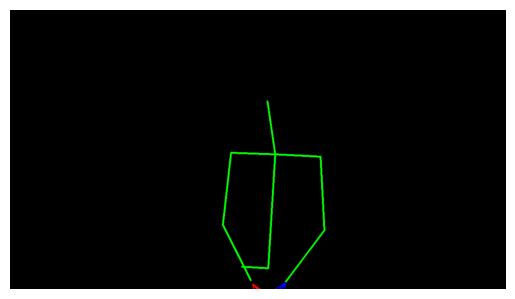

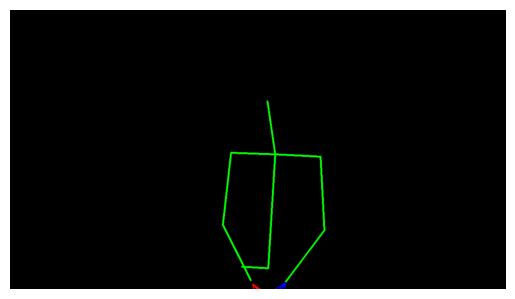

In [75]:
animate_sequence_notebook(poses)
